In [1]:
!pip install tkan pandas numpy matplotlib scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from tkan import TKAN, BSplineActivation, PowerSplineActivation, FixedSplineActivation # import from the installed tkan package
from utils.minmaxscaler import MinMaxScaler # utils is the folder next to this file, change it with your scaler if not using the whole folder or copy the class
from sklearn.metrics import r2_score

tf.keras.utils.set_random_seed(1) 
tf.config.experimental.enable_op_determinism() # Deterministic mode, not required but usefull to reproduce the results 

2024-05-18 12:03:02.754676: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 12:03:04.430290: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Datas from Binance gathered using the API
df = pd.read_parquet('data.parquet')
df = df[(df.index >= pd.Timestamp('2020-01-01')) & (df.index < pd.Timestamp('2023-01-01'))]
assets = ['BTC', 'ETH', 'ADA', 'XMR', 'EOS', 'MATIC', 'TRX', 'FTM', 'BNB', 'XLM', 'ENJ', 'CHZ', 'BUSD', 'ATOM', 'LINK', 'ETC', 'XRP', 'BCH', 'LTC']
df = df[[c for c in df.columns if 'quote asset volume' in c and any(asset in c for asset in assets)]]
df.columns = [c.replace(' quote asset volume', '') for c in df.columns]
df

,BTC,ADA,XMR,EOS,CHZ,MATIC,TRX,ENJ,FTM,BNB,XLM,BUSD,ATOM,LTC,LINK,ETC,ETH,XRP,BCH
group,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,3.675857e+06,38189.176211,4.539598e+04,94778.577031,817.146319,31003.791035,481993.354990,15241.945783,1165.788613,8.498617e+05,9460.819556,1.352376e+04,31986.972694,1.165827e+05,24281.170262,56488.402352,1.000930e+06,2.579254e+05,178258.749391
2020-01-01 01:00:00,6.365953e+06,51357.010954,3.348395e+04,593292.135445,886.460339,84465.335718,533668.554562,11896.843688,413.844612,7.405759e+05,37141.909518,2.531605e+04,81777.666046,2.830715e+05,51190.975142,182102.074213,1.474278e+06,4.520609e+05,615321.025242
2020-01-01 02:00:00,4.736719e+06,36164.263914,1.573255e+04,266732.556000,1819.795050,113379.718506,387049.986770,30109.770521,3559.965968,1.039091e+06,16878.822627,1.390886e+04,195731.175551,2.402871e+05,28721.756184,134063.422732,9.940256e+05,4.414948e+05,221535.645771
2020-01-01 03:00:00,5.667367e+06,24449.953815,2.575105e+04,124516.579473,2979.655803,41771.707995,450772.139235,6732.833578,4076.415482,4.975018e+05,9049.223394,2.251969e+04,120113.343316,1.613043e+05,29596.222534,131094.172168,6.473610e+05,1.886061e+05,397185.950571
2020-01-01 04:00:00,3.379094e+06,44502.669843,6.295563e+04,421819.671410,1023.388675,22254.756114,284788.973752,846.938455,633.367505,4.751285e+05,7254.260203,1.122460e+04,19989.169106,2.214516e+05,54514.370016,134937.122201,4.430067e+05,2.279373e+05,316499.137509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,6.704605e+07,581680.400510,3.873989e+05,48359.865300,199491.822800,890911.573610,225136.420055,40281.859330,159553.944500,9.889098e+05,39230.588600,6.560756e+06,180809.784710,9.964355e+05,190664.976300,181340.756100,7.738029e+06,1.413563e+06,35409.149500
2022-12-31 20:00:00,4.344849e+07,323561.762270,1.379392e+05,37858.704700,173057.240300,333511.762200,157069.026827,42228.830930,270251.374500,6.032059e+05,52964.531800,7.255324e+06,276013.421720,1.173164e+06,265727.950340,90513.087600,4.278879e+06,1.113527e+06,42674.516600
2022-12-31 21:00:00,5.992803e+07,455185.698060,2.445869e+05,79538.050600,107544.609700,525037.759990,180404.744820,27446.620810,198885.610000,1.386864e+06,44485.594800,8.712142e+06,476151.071190,6.820723e+05,265687.852060,85399.066100,4.643401e+06,1.373231e+06,38027.858800


In [4]:
N_MAX_EPOCHS = 1000
BATCH_SIZE = 128
early_stopping_callback = lambda : tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.000001,
    patience=6,
    mode="min",
    restore_best_weights=True,
    start_from_epoch=10,
)
lr_callback = lambda : tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    mode="min",
    min_delta=0.000001,
    min_lr=0.000025,
    verbose=0,
)
callbacks = lambda : [early_stopping_callback(), lr_callback(), tf.keras.callbacks.TerminateOnNaN()]


In [5]:
def generate_data(df, sequence_length, n_ahead):
    scaler_df = df.copy().shift(n_ahead).rolling(24 * 14).median() # We keep the scaling in case we want to unscale
    tmp_df = df.copy() / scaler_df # First preprocessing to make the serie more stationnary as volumes are definetly not
    tmp_df = tmp_df.iloc[24 * 14 + n_ahead:].fillna(0.)  # remove the part that is not defined and fill nan with 0 (case we had a division with 0, very unlikely except if an asset didn't trade half of the time during 2 weeks)
    scaler_df = scaler_df.iloc[24 * 14 + n_ahead:].fillna(0.) # Do the same as above here to keep align
    def prepare_sequences(df, scaler_df, n_history, n_future):
        """
        Creates sequences with original datas, use the first column as target (in our case BTC)
        past sequences goes from i - n_history included to i excluded
        future sequence goes from i  included to i + n_ahead excluded
        Also align the initial scaler values to keep track if we want to unscale later
        """
        X, y, y_scaler = [], [], []
        num_features = df.shape[1]
        
        # Iterate through the DataFrame to create sequences
        for i in range(n_history, len(df) - n_future + 1):
            # Extract the sequence of past observations
            X.append(df.iloc[i - n_history:i].values)
            # Extract the future values of the first column
            y.append(df.iloc[i:i + n_future,0:1].values)
            y_scaler.append(scaler_df.iloc[i:i + n_future,0:1].values)
        
        X, y, y_scaler = np.array(X), np.array(y), np.array(y_scaler)
        return X, y, y_scaler
    
    # Prepare sequences
    X, y, y_scaler = prepare_sequences(tmp_df, scaler_df, sequence_length, n_ahead)
    
    # Split the dataset into training and testing sets using  80/20 - We do not shuffle as this is time series it would create forward looking to do so here
    train_test_separation = int(len(X) * 0.8)
    X_train_unscaled, X_test_unscaled = X[:train_test_separation], X[train_test_separation:]
    y_train_unscaled, y_test_unscaled = y[:train_test_separation], y[train_test_separation:]
    y_scaler_train, y_scaler_test = y_scaler[:train_test_separation], y_scaler[train_test_separation:]

    # Using Min max scaling for numerical stability - default target range is [0,1] - the scaler is applied to each features separatly 
    X_scaler = MinMaxScaler(feature_axis=2)
    X_train = X_scaler.fit_transform(X_train_unscaled)
    X_test = X_scaler.transform(X_test_unscaled)
    
    y_scaler = MinMaxScaler(feature_axis=2)
    y_train = y_scaler.fit_transform(y_train_unscaled)
    y_test = y_scaler.transform(y_test_unscaled)

    # Here 
    y_train = y_train.reshape(y_train.shape[0], -1) 
    y_test = y_test.reshape(y_test.shape[0], -1)
    return X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test


/home/remi/.pyenv/versions/ntkan/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2024-05-18 12:03:12.713242: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "tkan_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tkan (TKAN)                     │ (None, 45, 100)        │        36,905 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_1 (TKAN)                   │ (None, 100)            │        62,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 9)              │           909 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,234 (391.54 KB)

 Trainable params: 100,234 (391.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 38s 116ms/step - loss: 0.0308 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 2/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - loss: 0.0032 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 3/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - loss: 0.0032 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 4/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - loss: 0.0032 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 5/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - loss: 0.0032 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 6/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.0031 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 7/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - loss: 0.0031 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 8/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.0031 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 9/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - loss: 0.0031 - val_lo

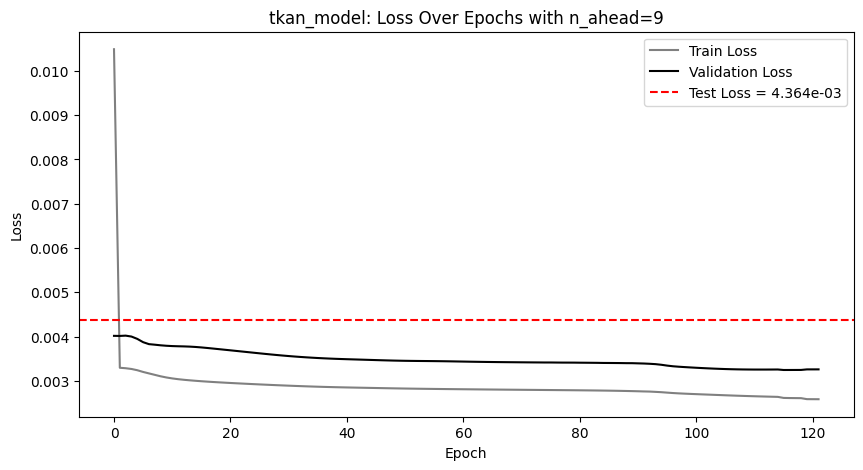


    Model Type: TKAN Model Result
    ------------------------------------
    Root Mean Squared Error (RMSE): 0.0661
    R-squared (R²) Score: 0.1307
    Mean Absolute Error (MAE): 0.0290
    


/home/remi/.pyenv/versions/ntkan/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 45, 100)        │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │           909 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,309 (505.11 KB)

 Trainable params: 129,309 (505.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.0035 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 2/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.0028 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 3/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0027 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 4/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0027 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 5/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0027 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 6/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0026 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 7/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 0.0026 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 8/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0026 - val_loss: 0.0034 - learning_rate: 5.0000e-04
Epoch 9/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.0025 - val_loss: 0.0034 

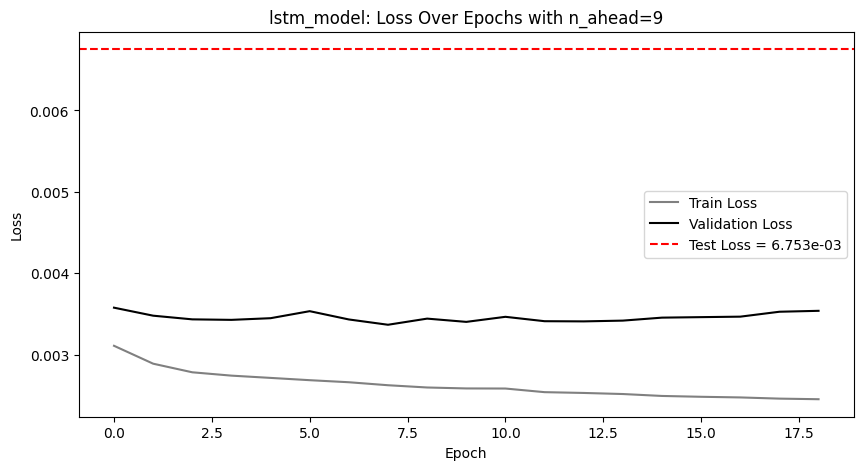


    Model Type: TKAN Model Result
    ------------------------------------
    Root Mean Squared Error (RMSE): 0.0822
    R-squared (R²) Score: -0.3451
    Mean Absolute Error (MAE): 0.0314
    


In [6]:
def evaluate_and_display(model, X, y):
    # Evaluate the model on the test set
    test_loss = model.evaluate(X, y)
    preds = model.predict(X)
    errors = preds - y
    rmse = np.sqrt(np.mean(np.square(errors)))
    r2 = r2_score(y_true=y.flatten(), y_pred=preds.flatten())
    mae = np.mean(np.abs(errors))
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(history.history['loss'])), history.history['loss'], label='Train Loss', color='grey')
    plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='Validation Loss', color='black')
    plt.title(f'{model.name}: Loss Over Epochs with n_ahead={y.shape[1]}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Optionally, plot test loss by adding it as a horizontal line or scatter point
    plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss = {test_loss:.3e}')
    plt.legend()
    plt.show()
    
    metrics_summary = f"""
    Model Type: TKAN Model Result
    ------------------------------------
    Root Mean Squared Error (RMSE): {rmse:.4f}
    R-squared (R²) Score: {r2:.4f}
    Mean Absolute Error (MAE): {mae:.4f}
    """
    print(metrics_summary)



n_ahead = 9
sequence_length = 5 * n_ahead
X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test = generate_data(df, sequence_length, n_ahead)

tkan_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
    TKAN(100, tkan_activations=[BSplineActivation() for _ in range(5)], return_sequences=True),  # Here tkan_activations can be left empty (in that case only one BSplineActivation), BSplineActivation default order is 3 but you can change it like [BSplineActivation(i) for i in range(5)] for example
    TKAN(100, tkan_activations=[BSplineActivation() for _ in range(5)], return_sequences=False), # But you can put any activation function from standard tensorflow or custom (any callable in fact), it should just be putted in a list 
    tf.keras.layers.Dense(y_train.shape[1], activation='linear'),
], name = 'tkan_model')

tkan_model.compile(optimizer='adam', loss='mean_squared_error')
tkan_model.summary()

history = tkan_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_MAX_EPOCHS, validation_split=0.2, callbacks=callbacks(), shuffle=True, verbose = True)

evaluate_and_display(tkan_model, X_test, y_test)


lstm_model=Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
    LSTM(100, return_sequences=True),
    LSTM(100, return_sequences=False),
    Dense(y_train.shape[1], activation='linear')
], name = 'lstm_model')


lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

history = lstm_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_MAX_EPOCHS, validation_split=0.2, callbacks=callbacks(), shuffle=True, verbose = True)

evaluate_and_display(lstm_model, X_test, y_test)

#The "UserWarning: Argument `input_shape` is deprecated. Use `shape` instead."" is normal, it is due to the change in the tensorflow-keras API, but input_shape is compatible with older version of tensorflow while shape is not